# The Heat Equation 

## The method of lines

(go to keynote)

The method of lines turns an initial boundary value PDE onto an initial value ODE.

The resulting system of ODEs may be very large.  For instance, if we have a PDE in 3 space dimensions, and discretize with 1000 points in each direction, we have one billion ODEs.

## Numerical methods for the heat equation


$$u_t = u_{xx}$$
$$u(x,t=0) = u_0(x)$$
$$u(x=\alpha,t) = u(x=\beta,t) = 0$$

Grid in $x$: $x_0=\alpha, x_1, x_2, \dots, x_m, x_{m+1}=\beta$. 

$x_i - x_{i-1} = h$

We studied the steady-state version of this problem earlier in the course.

First we discretize in space.  For instance, we can use a 2nd-order centered difference:

$$u_{xx}|_{x=x_i} \approx \frac{U_{i+1} - 2U_i + U_{i-1}}{h^2}$$

We get the ODE system $U'(t) = AU(t)$:

$$\begin{bmatrix}  U_1 \\ \vdots \\ U_m \end{bmatrix}' =  \frac{1}{h^2}\begin{bmatrix} -2 & 1 & \\ 1 & -2 & 1 & \\ & 1 & -2 & 1 & \\ && \ddots & \ddots & \ddots \\ & & & 1 & -2 \end{bmatrix} \begin{bmatrix} U_1 \\ \vdots \\ U_m \end{bmatrix}$$

Now we can apply any ODE solver we like, such as a Runge-Kutta or linear multistep method.

What time step size $k$ should we use?

Recall the eigenvalues of $A$:

$$\lambda_p = \frac{2}{h^2} (\cos(p\pi h)-1)$$

All eigenvalues are real and negative.  Earlier, we were interested in the behavior of $A^{-1}$ as $h\to 0$, so we studied the smallest eigenvalue of $A$.

Now we are interested in whether the eigenvalues of $A$ all fit within the absolute stability region of our ODE solver, so we will study the largest eigenvalue of $A$.  How large is it?

The largest eigenvalue $\lambda_\text{max}$ is obtained when the cosine is approximately -1, giving 

$$\lambda_\text{max}\approx -4/h^2.$$

$$U'(t) = AU(t)$$

Suppose we discretize with the explicit Euler method:

$$U^{n+1} = U^n + kAU^n$$

How large can we take $k$?

We need 

$$-\frac{4}{h^2}k \ge -2$$

so we have to take

$$k \le \frac{h^2}{2}.$$

We'd like to use a small $h$ to get good accuracy, but then we will need an extremely small value of $k$.

In fact, if we apply any explicit method, we'll need to take $k = {\mathcal O}(h^2)$.

## Local truncation error

We can write the full discretization using Euler in time and a 3-point centered difference in space:

$$
\frac{U_i^{n+1} - U_i^n}{k} = \frac{U_{i+1}^n - 2U_i^n + U_{i-1}^n}{h^2}.
$$

What is the local truncation error?

We substitute the exact solution:
    
$$
  \frac{u(x_i,t_n+k) - u(x_i,t_n)}{k} = \frac{u(x_{i+1},t_n)-2u(x_i,t_n)+u(x_{i-1},t_n)}{h^2} + \tau_i^n.
$$

We have worked these out before:

$$\frac{u(x_i,t_n+k) - u(x_i,t_n)}{k} = u_t + \frac{k}{2}u_{tt} + \frac{k^2}{6}u_{ttt} + {\mathcal O}(k^3)$$

$$\frac{u(x_{i+1},t_n)-2u(x_i,t_n)+u(x_{i-1},t_n)}{h^2} = u_{xx} + \frac{h^2}{12}u_{xxxx} + {\mathcal O}(h^4)$$

Thus we have

\begin{align*}
    \tau_i^n & = u_t - u_{xx} + \frac{k}{2}u_{tt} - \frac{h^2}{12} u_{xxxx} + {\mathcal O}(k^2) + {\mathcal O}(h^4) \\
            & = \frac{k}{2}u_{tt} - \frac{h^2}{12} u_{xxxx} + {\mathcal O}(k^2) + {\mathcal O}(h^4)
\end{align*}

We see that the method is first order in time and second order in space, just as we would expect.

The method of lines allows us to choose independently the order of accuracy of our discretization in time and space.  Usually we would like to match them.

# Stiffness and the behavior of the heat equation
The heat equation is infinitely stiff, and when we discretize it in space we get a very stiff system of ODEs.  Let's investigate.

Consider the problem on $[0,1]$ with homogeneous Dirichlet boundary conditions:
\begin{align*}
    u_t & = u_{xx} \\
    u(0,t) & = u(1,t) = 0 \\
    u(x,0) & = u_0(x).
\end{align*}

In your PDEs course you learned how to solve this.  We can write the solution as a sum of sine functions:

$$
u(x,t) = \sum_{j=1}^\infty \hat{u}_j(t) \sin(j\pi x).
$$

Plugging this into the PDE gives

$$
\hat{u}'_j(t) = -j^2 \pi^2 \hat{u}_j(t),
$$

with solution

$$
\hat{u}_j(t) = e^{-j^2\pi^2 t} \hat{u}_j(0).
$$

Thus we have

$$
u(x,t) = \sum_{j=1}^\infty \hat{u}_j(0) e^{-j^2\pi^2t}\sin(j\pi x).
$$

Notice that the shorter-wavelength modes decay much more quickly.  For $j=1$ the time dependence is $e^{-\pi^2t}$,
while for the $j=100$ mode it is $e^{-10000\pi^2t}$!

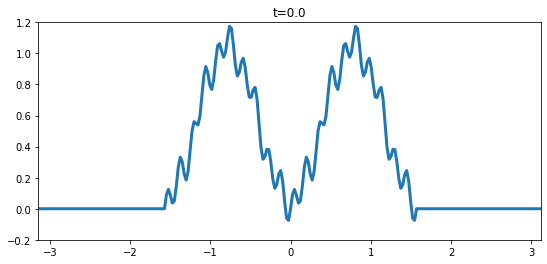

In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from IPython.display import HTML

a = 0.1; b=0.1   # CHANGE THESE

# Spatial grid
m=256                            # Number of grid points in space
L = 2 * np.pi                   # Width of spatial domain
x = np.arange(-m/2,m/2)*(L/m)   # Grid points
dx = x[1]-x[0]                  # Grid spacing

# Temporal grid
tmax=1.0     # Final time
N = 100       # number grid points in time
k = tmax/N   # interval between output times

xi = np.fft.fftfreq(m)*m*2*np.pi/L  # Wavenumber "grid"
# (this is the order in which numpy's FFT gives the frequencies)

# Initial data
u = (np.sin(2*x)**2 + a*np.sin(10*x)**2 + b*np.sin(40*x)) * (np.abs(x)<L/4)
#u = (np.sin(2*x)**2) * (x<-L/4)
uhat0 = np.fft.fft(u)

epsilon=0.1  # Diffusion coefficient
a = 0.0       # Advection coefficient

# Store solutions in a list for plotting later
frames = [u.copy()]

# Now we solve the problem
for n in range(1,N+1):
    t = n*k
    uhat = np.exp(-(1.j*xi*a + epsilon*xi**2)*t) * uhat0
    u = np.real(np.fft.ifft(uhat))
    frames.append(u.copy())

# Set up plotting
fig = plt.figure(figsize=(9,4)); axes = fig.add_subplot(111)
line, = axes.plot(x,np.sin(2*x)**2 * (x<-L/4),lw=3)
axes.set_xlim((x[0],x[-1])); axes.set_ylim((-0.2,1.2))

def plot_frame(i):
    #fig = plt.figure()
    #plt.plot(x,frames[i])
    line.set_data(x,frames[i])
    axes.set_title('t='+str(i*k))
    fig.canvas.draw()
    return fig

# Animate the solution
anim = matplotlib.animation.FuncAnimation(fig, plot_frame,
                                   frames=len(frames),
                                   interval=200,
                                   repeat=False);

In [47]:
HTML(anim.to_jshtml())

We see that:

 - The high-frequency modes decay very rapidly
 - The low-frequency modes decay slowly
 
This is very similar to the stiff ODE we looked at.  If we have an initial condition with only low-frequency parts, it will evolve slowly.  But there are "nearby" solutions with small high-frequency parts that decay very rapidly.  This makes the problem stiff.

The time step size we can use is dictated by the decay of the fastest-changing mode.  In the continuous problem, there are modes of arbitrarily high frequency that decay arbitrarily fast, since the derivative of $\exp(-j^2\pi^2t)$ blows up as $j \to \infty$.  But when we introduce a grid in space, we restrict the range of frequencies that can be represented on our grid, so we end up with a system of ODEs with finite stiffness.

What kind of numerical ODE solver should we use for this problem?

In [35]:
from scipy.optimize import fsolve
from nodepy import rk

def DIRK(rkm, dt, f, w0=[1.,0], t_final=1.):

    w = np.array(w0)
    t = 0
    # We pre-allocate extra space because if rescale_step==True then
    # we don't know exactly how many steps we will take.
    ww = np.zeros([len(w0),int((t_final-t)/dt*2.5)+10000])
    ww[:,0] = w.copy()
    tt = [t]
    ii = 0
    s = len(rkm)
    b = rkm.b
    y = np.zeros((s,len(w0)))
    
    while t < t_final:
        if t + dt >= t_final:
            dt = t_final - t # Hit final time exactly
        
        for i in range(s):
            stageeq = lambda Y: (Y-w-dt*sum([rkm.A[i,j]*f(y[j,:]) for j in range(i)]) \
                                 - dt*rkm.A[i,i]*f(Y)).squeeze()
            nexty, info, ier, mesg = fsolve(stageeq,w,full_output=1)
            if ier != 1: print(mesg)
            y[i,:] = nexty.copy()
  
        F = np.array([f(y[i,:]) for i in range(s)])
        dw = dt*sum([b[j]*F[j] for j in range(s)])
        
        w = w + dw    
        t += dt
        ii += 1
        tt.append(t)
        ww[:,ii] = w.copy()
    return tt, ww[:,:ii+1]
    
trbdf = rk.loadRKM('TR-BDF2').__num__()
be = rk.loadRKM('BE').__num__()
irk2 = rk.loadRKM('LobattoIIIA2').__num__()

In [55]:
N=100
x = np.linspace(0,1,N)
dx = x[1]-x[0]

def f_heat(u):
    du = np.zeros_like(u)
    du[1:-1] = (u[2:]-2*u[1:-1]+u[:-2])
    du[0] = -2*u[0]+u[1]
    du[-1] = u[-2]-2*u[-1]
    return du/dx**2


u0 = 1.*(0.25<x)*(x<0.75)
#u0 = np.exp(-100*(x-0.5)**2)
dt = 1.*dx

tt, uu = DIRK(irk2,dt=dt,f=f_heat,w0=u0,t_final=0.1)

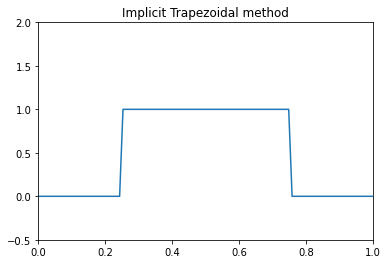

In [56]:
from matplotlib import animation

fig = plt.figure()
line, = plt.plot([],[])
plt.title('Implicit Trapezoidal method')
plt.ylim(-0.5,2)
plt.xlim(0,1)

def plot_frame(j):
    line.set_data(x,uu[:,j]);
    
anim = animation.FuncAnimation(fig,plot_frame,frames=uu.shape[1])

In [57]:
HTML(anim.to_jshtml())

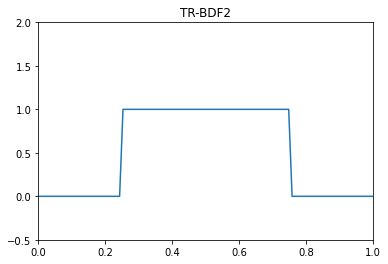

In [44]:
tt, uu = DIRK(trbdf,dt=dt,f=f_heat,w0=u0,t_final=0.1)

fig = plt.figure()
line, = plt.plot([],[])
plt.title('TR-BDF2')
plt.ylim(-0.5,2)
plt.xlim(0,1)

def plot_frame(j):
    line.set_data(x,uu[:,j]);
    
anim = animation.FuncAnimation(fig,plot_frame,frames=uu.shape[1])

In [45]:
HTML(anim.to_jshtml())